In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm import tqdm
from dandi.dandiapi import DandiAPIClient

In [2]:
def get_last_author(metadata):
    if 'contributor' not in metadata:
        return ''
    contributors = metadata['contributor']
    contributors = [
        x for x in contributors 
        if x["schemaKey"] == "Person" 
        and x["includeInCitation"]
    ]
    if not len(contributors):
        return ''
    return contributors[-1]["name"]

def get_data_standard(assetsSummary):
    if 'dataStandard' not in assetsSummary:
        return None
    if not len(assetsSummary['dataStandard']):
        return None
    return assetsSummary['dataStandard'][0].get('identifier', None)

In [3]:
data = []
with DandiAPIClient() as client:
    for dandiset in tqdm(client.get_dandisets()):
        metadata = dandiset.get_raw_metadata()
        assetsSummary = metadata['assetsSummary']
        if get_data_standard(assetsSummary) == 'RRID:SCR_015242':  # NWB
            data.append(
                dict(
                    identifier=dandiset.identifier,
                    created=dandiset.created,
                    size=assetsSummary['numberOfBytes']/1e12,  # TB
                    last_author=get_last_author(metadata),
                    sessions=assetsSummary["numberOfFiles"],
                    subject=assetsSummary.get("numberOfSubjects", 0)
                ) 
            )
            
df = pd.DataFrame(data)

91it [00:04, 19.68it/s]


In [4]:
def plot_progress_by_author(df, column_name='size', ax=None, nkeep=9):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    top_authors = df.groupby('last_author').sum().sort_values(column_name, ascending=False).index.values

    use_author = lambda x: x if x.strip() in top_authors else 'other'

    top_authors = top_authors[np.logical_not(np.isin(top_authors, ('', 'Last, First')))][:nkeep]

    df['author_or_other'] = df['last_author'].apply(use_author)
    
    order = np.argsort(df[df['author_or_other'] != 'other'].groupby('author_or_other')['created'].min()).values
    
    top_authors = top_authors[order]

    data = [np.cumsum(df[column_name] * (df['author_or_other'] == author).astype('int')).to_numpy()
            for author in list(top_authors) + ['other']]


    Y = np.vstack(data)
    x = [x.to_pydatetime() for x in df['created']]

    Y = np.hstack((np.zeros((10,1)), np.repeat(Y, 2, axis=1)))
    x = np.hstack((np.repeat(x, 2), datetime.now()))

    _ = plt.stackplot(x, Y, labels=list(top_authors) + ['other'])

    fig.autofmt_xdate()
    plt.legend(loc=2)
    ax.set_xlim((min([_.date() for _ in x]), max([_.date() for _ in x])))

    return ax


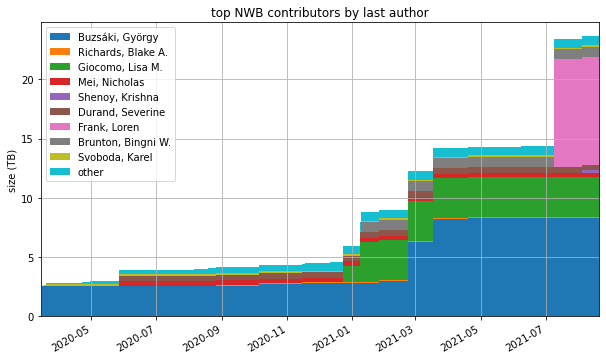

In [5]:
ax = plot_progress_by_author(df, 'size')
ax.set_title('top NWB contributors by last author')
ax.set_ylabel('size (TB)')
ax.grid('on')

plt.savefig('dandi_timeline.pdf')
plt.savefig('dandi_timeline.png', bbox_inches='tight')